In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from tensorflow.keras.utils import image_dataset_from_directory

2026-02-12 09:53:13.390527: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-12 09:53:15.137643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-12 09:53:20.896168: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# Prevent TensorFlow from locking up all GPU VRAM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
training_set = image_dataset_from_directory(
    'dataset_split/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 2949 files belonging to 4 classes.


I0000 00:00:1770890030.759628    1710 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [ ]:
validation_set = image_dataset_from_directory(
    'dataset_split/val',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 631 files belonging to 4 classes.


In [ ]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
INPUT_SHAPE = (224, 224, 3)

In [ ]:
mobnet = tf.keras.applications.MobileNetV3Large(
    input_shape=INPUT_SHAPE,
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
    # name="MobileNetV3Large",
)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


In [ ]:
mobnet.trainable = False

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=INPUT_SHAPE))
model.add(mobnet)
model.add(tf.keras.layers.Dense(units = 4,activation='softmax'))

In [ ]:
metrics_list = ['accuracy',
                tf.keras.metrics.F1Score()]

In [ ]:
# Define a scheduler to prevent the model from plateauing
initial_learning_rate = 0.0005  # Slightly higher than your current 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule),loss='categorical_crossentropy',metrics=metrics_list,jit_compile=False)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7, 7, 4)        │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 3,844 (15.02 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
training_history = model.fit(x=training_set,validation_data=validation_set,epochs=15)

Epoch 1/15


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 4), output.shape=(None, 7, 7, 4)

In [ ]:
mobnet = tf.keras.applications.MobileNetV3Large(
    input_shape=INPUT_SHAPE,
    alpha=1.0,
    minimalistic=False,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling='avg',
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
    # name="MobileNetV3Large",
)

In [ ]:
mobnet.trainable = False

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=INPUT_SHAPE))
model.add(mobnet)
model.add(tf.keras.layers.Dense(units = 4,activation='softmax'))

In [ ]:
metrics_list = ['accuracy',
                tf.keras.metrics.F1Score()]

In [ ]:
# Define a scheduler to prevent the model from plateauing
initial_learning_rate = 0.0005  # Slightly higher than your current 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule),loss='categorical_crossentropy',metrics=metrics_list,jit_compile=False)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 3,844 (15.02 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [ ]:
training_history = model.fit(x=training_set,validation_data=validation_set,epochs=15)

Epoch 1/15


2026-02-12 09:58:49.876845: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


369/369 ━━━━━━━━━━━━━━━━━━━━ 43s 83ms/step - accuracy: 0.7040 - f1_score: 0.7041 - loss: 0.7535 - val_accuracy: 0.8209 - val_f1_score: 0.8232 - val_loss: 0.5346
Epoch 2/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.8454 - f1_score: 0.8447 - loss: 0.4370 - val_accuracy: 0.8574 - val_f1_score: 0.8588 - val_loss: 0.4273
Epoch 3/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.8739 - f1_score: 0.8730 - loss: 0.3635 - val_accuracy: 0.8811 - val_f1_score: 0.8816 - val_loss: 0.3677
Epoch 4/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8895 - f1_score: 0.8882 - loss: 0.3226 - val_accuracy: 0.8780 - val_f1_score: 0.8791 - val_loss: 0.3474
Epoch 5/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.9020 - f1_score: 0.9005 - loss: 0.2954 - val_accuracy: 0.8986 - val_f1_score: 0.8988 - val_loss: 0.3257
Epoch 6/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9074 - f1_score: 0.9059 - loss: 0.2744 - val_accuracy: 0.8970 - val_f1_score: 0.897

In [ ]:
model.save("Trained_Model.keras")

In [ ]:
# Saving history
with open('Training_history.pkl', 'wb') as f:
    pickle.dump(training_history.history, f)

In [ ]:
with open('Training_history.pkl', 'rb') as f:
    load_history = pickle.load(f)
load_history

{'accuracy': [0.7039674520492554,
  0.8453713059425354,
  0.8738555312156677,
  0.8894540667533875,
  0.9020006656646729,
  0.9074262380599976,
  0.9121736288070679,
  0.9135299921035767,
  0.9189555644989014,
  0.9189555644989014,
  0.9270939230918884,
  0.926415741443634,
  0.926415741443634,
  0.9318413138389587,
  0.9331976771354675],
 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.78606963, 0.72480613, 0.6381435 , 0.66751915], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.88583213, 0.9       , 0.78084177, 0.81226045], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.89993095, 0.93580407, 0.81249994, 0.84378994], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9082125, 0.9560078, 0.8245614, 0.8639281], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.91557986, 0.97056895, 0.8377192 , 0.87823826], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=arra

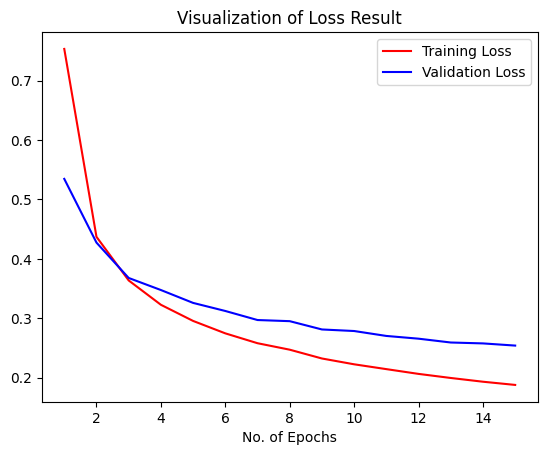

In [ ]:
#Loss Visualization
epochs = [i for i in range(1,16)]
plt.plot(epochs,load_history['loss'],color='red',label='Training Loss')
plt.plot(epochs,load_history['val_loss'],color='blue',label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Loss Result')
plt.legend()
plt.show()

In [ ]:
test_set = validation_set = image_dataset_from_directory(
    'data_split/test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

NotFoundError: Could not find directory data_split/test

In [ ]:
test_set = validation_set = image_dataset_from_directory(
    'dataset_split/test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 637 files belonging to 4 classes.


In [ ]:
test_set = image_dataset_from_directory(
    'dataset_split/test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 637 files belonging to 4 classes.


In [ ]:
test_loss,test_acc,f1_score = model.evaluate(test_set)
test_loss
test_acc
f1_score

80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 0.8995 - f1_score: 0.8977 - loss: 0.2644


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9202453 , 0.9726443 , 0.83561635, 0.8623853 ], dtype=float32)>

In [ ]:
'-----------------------MODEL EVALUATION-----------------------------'
model = tf.keras.models.load_model("Trained_Model.keras")

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,007,885 (11.47 MB)

 Trainable params: 3,844 (15.02 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 7,689 (30.04 KB)

In [ ]:
test_set = validation_set = image_dataset_from_directory(
    'test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(224, 224),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

NotFoundError: Could not find directory test

In [ ]:
test_set = image_dataset_from_directory(
    'dataset_split/test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=8,
    image_size=(224, 224),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 637 files belonging to 4 classes.


In [ ]:
##Computing True labels from test set
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

2026-02-12 10:11:45.890259: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
Y_true

<tf.Tensor: shape=(637,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     

In [ ]:
##Computing Predicted labels from test set
predicted_categories = model.predict(test_set)
Y_pred = tf.argmax(predicted_categories, axis=1)

80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step 


In [ ]:
Y_true

<tf.Tensor: shape=(637,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     

In [ ]:
Y_pred

<tf.Tensor: shape=(637,), dtype=int64, numpy=
array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true,Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       157
           1       0.98      0.96      0.97       166
           2       0.87      0.80      0.84       152
           3       0.85      0.87      0.86       162

    accuracy                           0.90       637
   macro avg       0.90      0.90      0.90       637
weighted avg       0.90      0.90      0.90       637



In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_true,Y_pred)
cm

array([[150,   0,   3,   4],
       [  1, 160,   3,   2],
       [  9,   3, 122,  18],
       [  9,   0,  12, 141]])

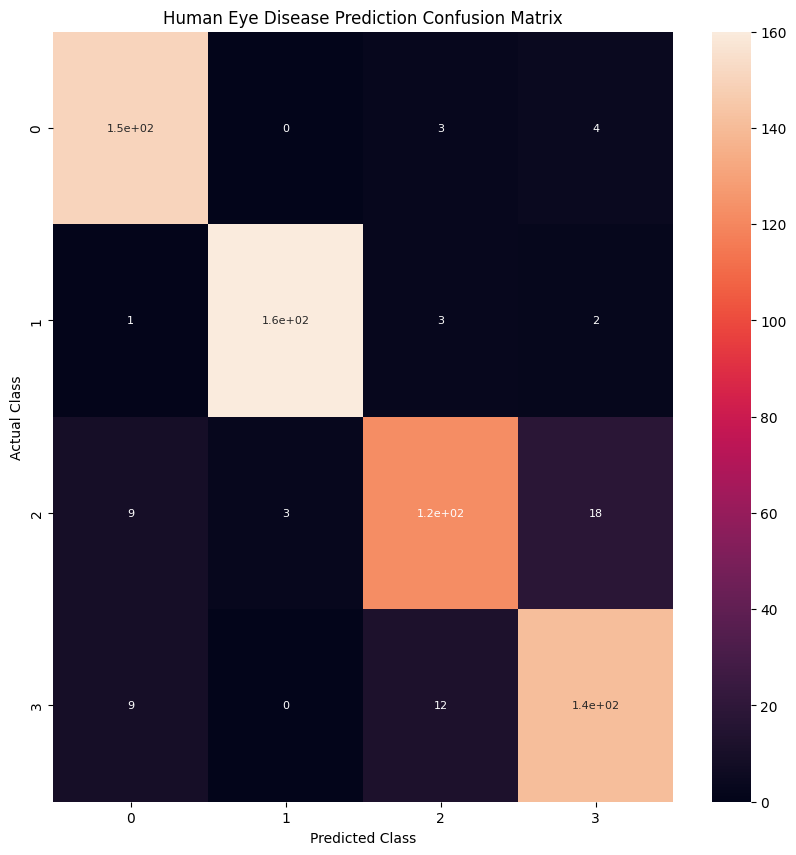

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,annot_kws={"size":8})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Human Eye Disease Prediction Confusion Matrix",fontsize=12)
plt.show()